<div style="direction: rtl; line-height: 300%;">
  <font face="XB Zar" size="5">
    <div align="center">
      <font face="IranNastaliq" size="30">
        <p></p>
      </font>
    </div>
    <br>
    <div align="center">
      <font color="brown" size="6">
        معین حسن پور - 40032313
      </font>
    </div>
    <br>
    <div align="right">
      <font color="navy">
        <b><u>تمرین دوم</u></b> پردازش تصویر رقمی
      </font>
    </div>
    <div align="center">
      تطبیق هیستوگرام
    </div>
    <hr>

  </font>
</div>
 <hr>
  </font>
</div>


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div

<hr>

> <h2>1- رسم هیستوگرام تصاویر


In [ ]:
def compare_gray_histograms(image_paths):    #image_paths= لیستی از مسیرهای تصاویر خاکستری

    plt.figure(figsize=(10, 5))
    plt.title("Comparison of Grayscale Histograms")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")

    for idx, img_path in enumerate(image_paths):
        image = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        if image is None:
            print(f"تصویر {img_path} یافت نشد!")
            continue

        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        plt.plot(hist, label=f"{img_path}")

    plt.legend()
    plt.xlim([0, 256])
    plt.show()


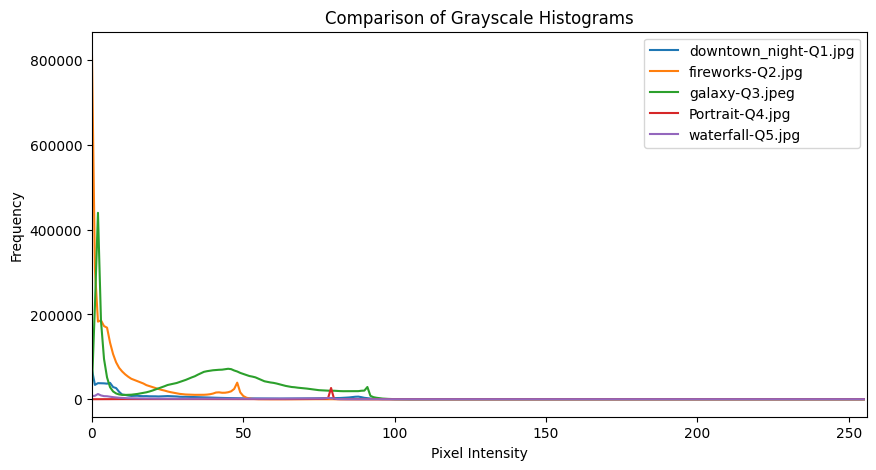

In [ ]:
image_list = ["downtown_night-Q1.jpg", "fireworks-Q2.jpg", "galaxy-Q3.jpeg", "Portrait-Q4.jpg", "waterfall-Q5.jpg"]
compare_gray_histograms(image_list)

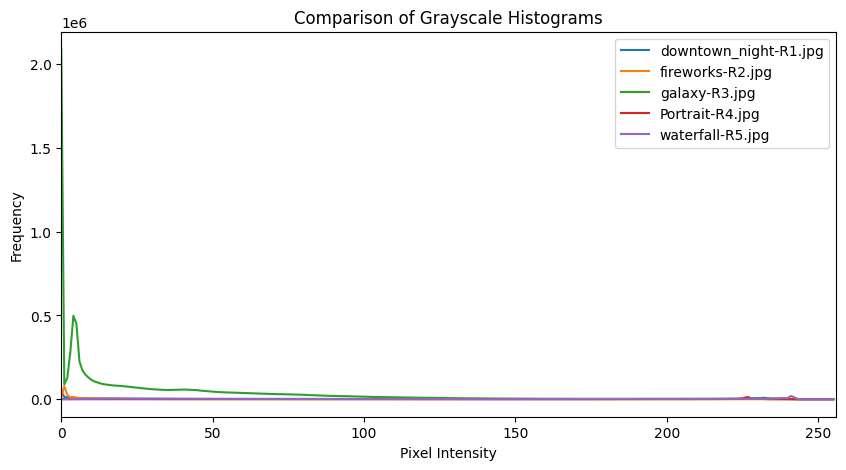

In [ ]:
image_list = ["downtown_night-R1.jpg", "fireworks-R2.jpg", "galaxy-R3.jpg", "Portrait-R4.jpg", "waterfall-R5.jpg"]
compare_gray_histograms(image_list)

<hr>

> <h2>2-1) مقایسه و انتخاب بهترین مرجع با روش jensen

> <h2>2-2) تطبیق هیستوگرام





In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial.distance import jensenshannon

def match_query_to_ref(query_path, ref_paths):
    # --- بخش 1: خواندن تصاویر  ---
    query_img = cv2.imread(query_path)
    if query_img is None:
        raise ValueError(f"خطا در خواندن تصویر کوئری: {query_path}")
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY) # تک کاناله کردن تصویر کوئری

    # محاسبه هیستوگرام
    query_hist = cv2.calcHist([query_gray], [0], None, [256], [0, 256])
    query_hist = cv2.normalize(query_hist, None, norm_type=cv2.NORM_L1).flatten() # نرمال سازی هیستوگرام کوئری

    # --- بخش 2: یافتن بهترین مرجع ---
    min_js = float('inf')
    best_ref_img = None
    best_ref_hist = None
    best_ref_path = ""

    for ref_path in ref_paths:
        ref_img = cv2.imread(ref_path)
        if ref_img is None:
            continue

        ref_gray = cv2.cvtColor(ref_img, cv2.COLOR_BGR2GRAY) #تک کاناله کردن تصویر مرجع
        ref_hist = cv2.calcHist([ref_gray], [0], None, [256], [0, 256]) # محاسبه هیستوگرام
        ref_hist = cv2.normalize(ref_hist, None, norm_type=cv2.NORM_L1).flatten() #نرمال سازی هیستوگرام

        # محاسبه فاصله جنسن-شانون با کتابخانه مورد نظر
        js = jensenshannon(query_hist, ref_hist) ** 2

        if js < min_js:
            min_js = js
            best_ref_img = ref_img
            best_ref_hist = ref_hist
            best_ref_path = ref_path

    if best_ref_img is None:
        raise ValueError("هیچ تصویر مرجع معتبری یافت نشد")

    # --- بخش 3: تطبیق هیستوگرام ---

      #محاسبه cdf:
    ref_cdf = best_ref_hist.cumsum()
    ref_cdf = (255 * (ref_cdf - ref_cdf.min()) / (ref_cdf.max() - ref_cdf.min())).astype(np.uint8)

    query_cdf = query_hist.cumsum()
    query_cdf = (255 * (query_cdf - query_cdf.min()) / (query_cdf.max() - query_cdf.min())).astype(np.uint8)

    lut = np.interp(query_cdf, ref_cdf, np.arange(256))
    matched_gray = cv2.LUT(query_gray, lut.astype(np.uint8))
    matched_img = cv2.cvtColor(matched_gray, cv2.COLOR_GRAY2BGR)

    # --- بخش 4: چاپ اطلاعات و نمایش نتایج ---
    # چاپ اطلاعات در خروجی
    print(f"Query Image: {os.path.basename(query_path)} - Best Match: {os.path.basename(best_ref_path)} - JS Distance: {min_js:.4f}")

    # نمایش گرافیکی
    plt.figure(figsize=(18, 12))

    # ردیف اول: تصاویر
    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB))
    plt.title('Query Image')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(best_ref_img, cv2.COLOR_BGR2RGB))
    plt.title(f'Best Reference (JS: {min_js:.4f})')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.title('Matched Image')
    plt.axis('off')

    # ردیف دوم: هیستوگرام‌ها
    plt.subplot(2, 3, 4)
    plt.plot(query_hist, color='k')
    plt.title('Query Histogram')
    plt.xlim([0, 255])
    plt.grid(True)

    plt.subplot(2, 3, 5)
    plt.plot(best_ref_hist, color='k')
    plt.title('Reference Histogram')
    plt.xlim([0, 255])
    plt.grid(True)

    matched_hist = cv2.calcHist([matched_gray], [0], None, [256], [0, 256])
    matched_hist = cv2.normalize(matched_hist, None, norm_type=cv2.NORM_L1).flatten()
    plt.subplot(2, 3, 6)
    plt.plot(matched_hist, color='k')
    plt.title('Matched Histogram')
    plt.xlim([0, 255])
    plt.grid(True)

    plt.tight_layout()
    plt.show()




<html lang="fa">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            direction: rtl;
            text-align: right;
            background-color: #f5f5f5;
            padding: 20px;
        }
        .container {
            background: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
            max-width: 600px;
            margin: auto;
        }
        h2 {
            color: #333;
        }
        ol {
            padding-right: 20px;
        }
    </style>
</head>
<body>
    <div class="container">
        <h2>در کد بالا مراحل زیر رخ میدهد:</h2>
        <ol>
            <li>خواندن تصاویر و تبدیل به خاکستری (بخش ۱: خطوط <code>cv2.imread</code> و <code>cvtColor</code>)</li>
            <li>محاسبه هیستوگرام‌ها (خطوط <code>calcHist</code> و <code>normalize</code>)</li>
            <li>یافتن نزدیک‌ترین مرجع (بخش ۲: حلقه <code>for</code> با <code>jensenshannon</code>)</li>
            <li>تطبیق هیستوگرام (بخش ۳: محاسبه <code>CDF</code> و <code>LUT</code>)</li>
            <li>نمایش نتایج (بخش ۴: <code>plt.subplot</code> و <code>plt.plot</code>)</li>
            <li>چاپ اطلاعات (خط <code>print</code> با <code>os.path.basename</code>)</li>
        </ol>
    </div>
<p>این کد از طریق تطبیق هیستوگرام، کیفیت تصویر را بهبود می‌دهد:
۱. انتخاب مرجع بهینه: با محاسبه فاصله جنسن-شانون، نزدیک‌ترین هیستوگرام مرجع به تصویر کوئری انتخاب می‌شود. (بهترین توزیع روشنایی)
۲. تنظیم کنتراست: با نگاشت پیکسل‌ها بر اساس CDF مرجع، کنتراست تصویر کوئری به مرجع شبیه‌سازی می‌شود.
۳. یکسان‌سازی طیف نوری: پیکسل‌های تصویر کوئری بازتوزیع می‌شوند تا طیف روشنایی تصویر هدف (مرجع) را تقلید کنند.
۴. حفظ جزئیات: تغییرات غیرمخرب بوده و ساختار اصلی تصویر دست نخورده باقی می‌ماند.

نتیجه: بهبود دیداری در نورپردازی، کنتراست و یکنواختی تصویر نهایی.
</p>
</body>
</html>


In [5]:

reference_images_list = ["downtown_night-R1.jpg","fireworks-R2.jpg", "galaxy-R3.jpg", "Portrait-R4.jpg", "waterfall-R5.jpg"]


<hr>
<div>
    <font size=5 color= navy>A) downtown night:
</div>

Query Image: downtown_night-Q1.jpg - Best Match: galaxy-R3.jpg - JS Distance: 0.0706


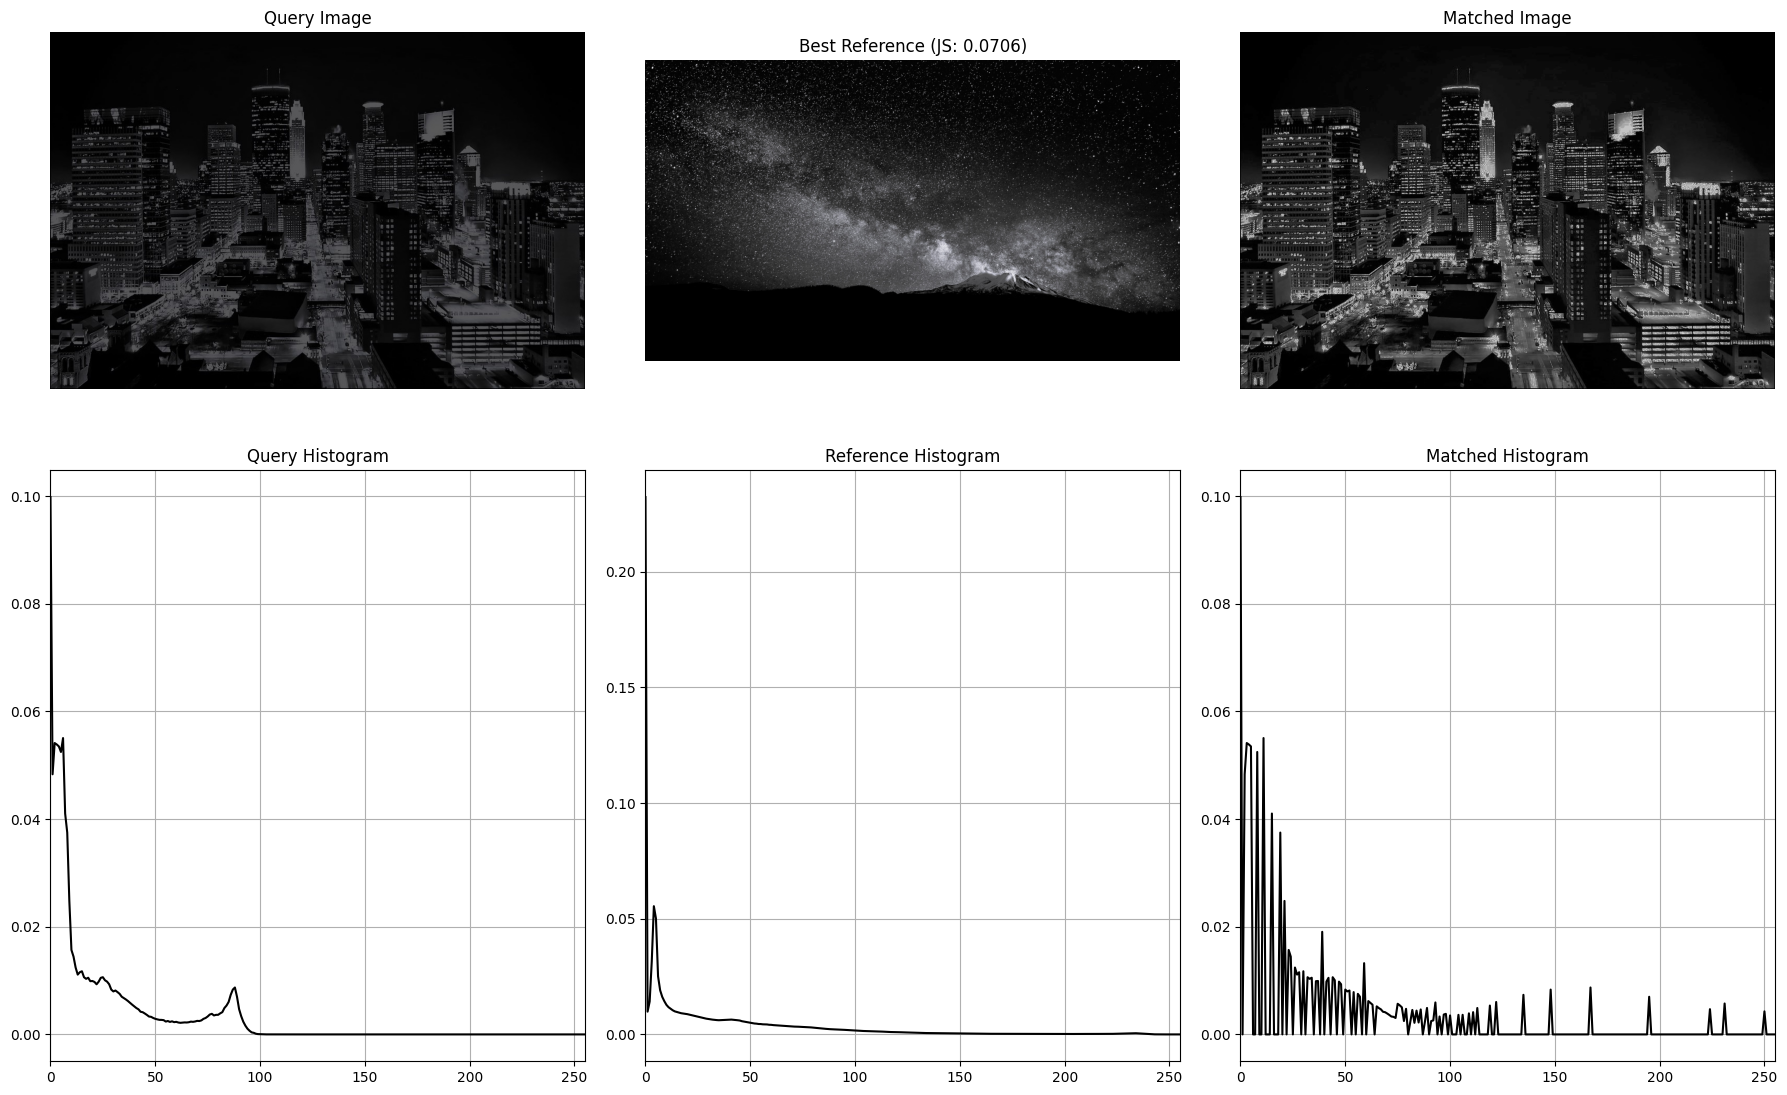

In [6]:
query_image_path = "downtown_night-Q1.jpg"  # آدرس تصویر کوئری

match_query_to_ref( query_image_path, reference_images_list)

<hr>
<div>
    <font size=5 color= navy>B) Firework:
</div>

Query Image: fireworks-Q2.jpg - Best Match: galaxy-R3.jpg - JS Distance: 0.1141


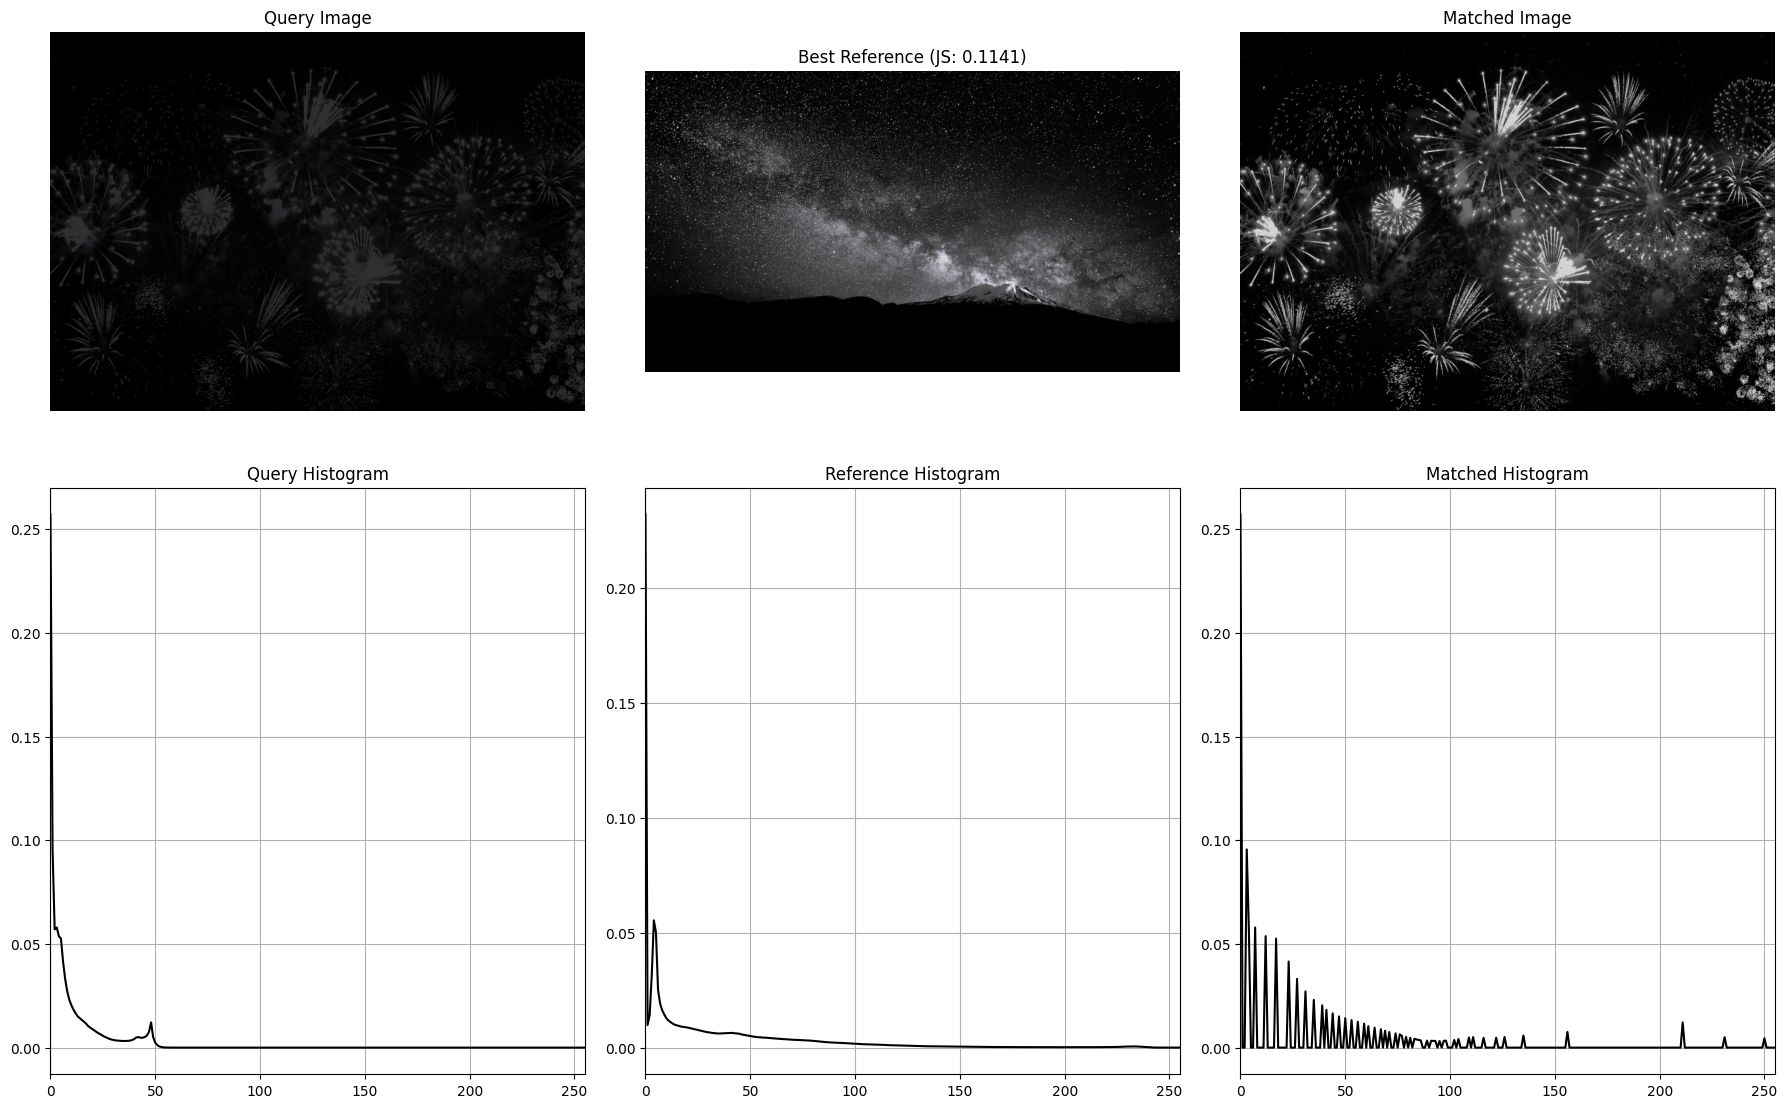

In [7]:
query_image_path = "fireworks-Q2.jpg"  # آدرس تصویر کوئری

match_query_to_ref( query_image_path, reference_images_list)

<hr>
<div>
    <font size=5 color= navy>C) Galaxy:
</div>

Query Image: galaxy-Q3.jpeg - Best Match: galaxy-R3.jpg - JS Distance: 0.1903


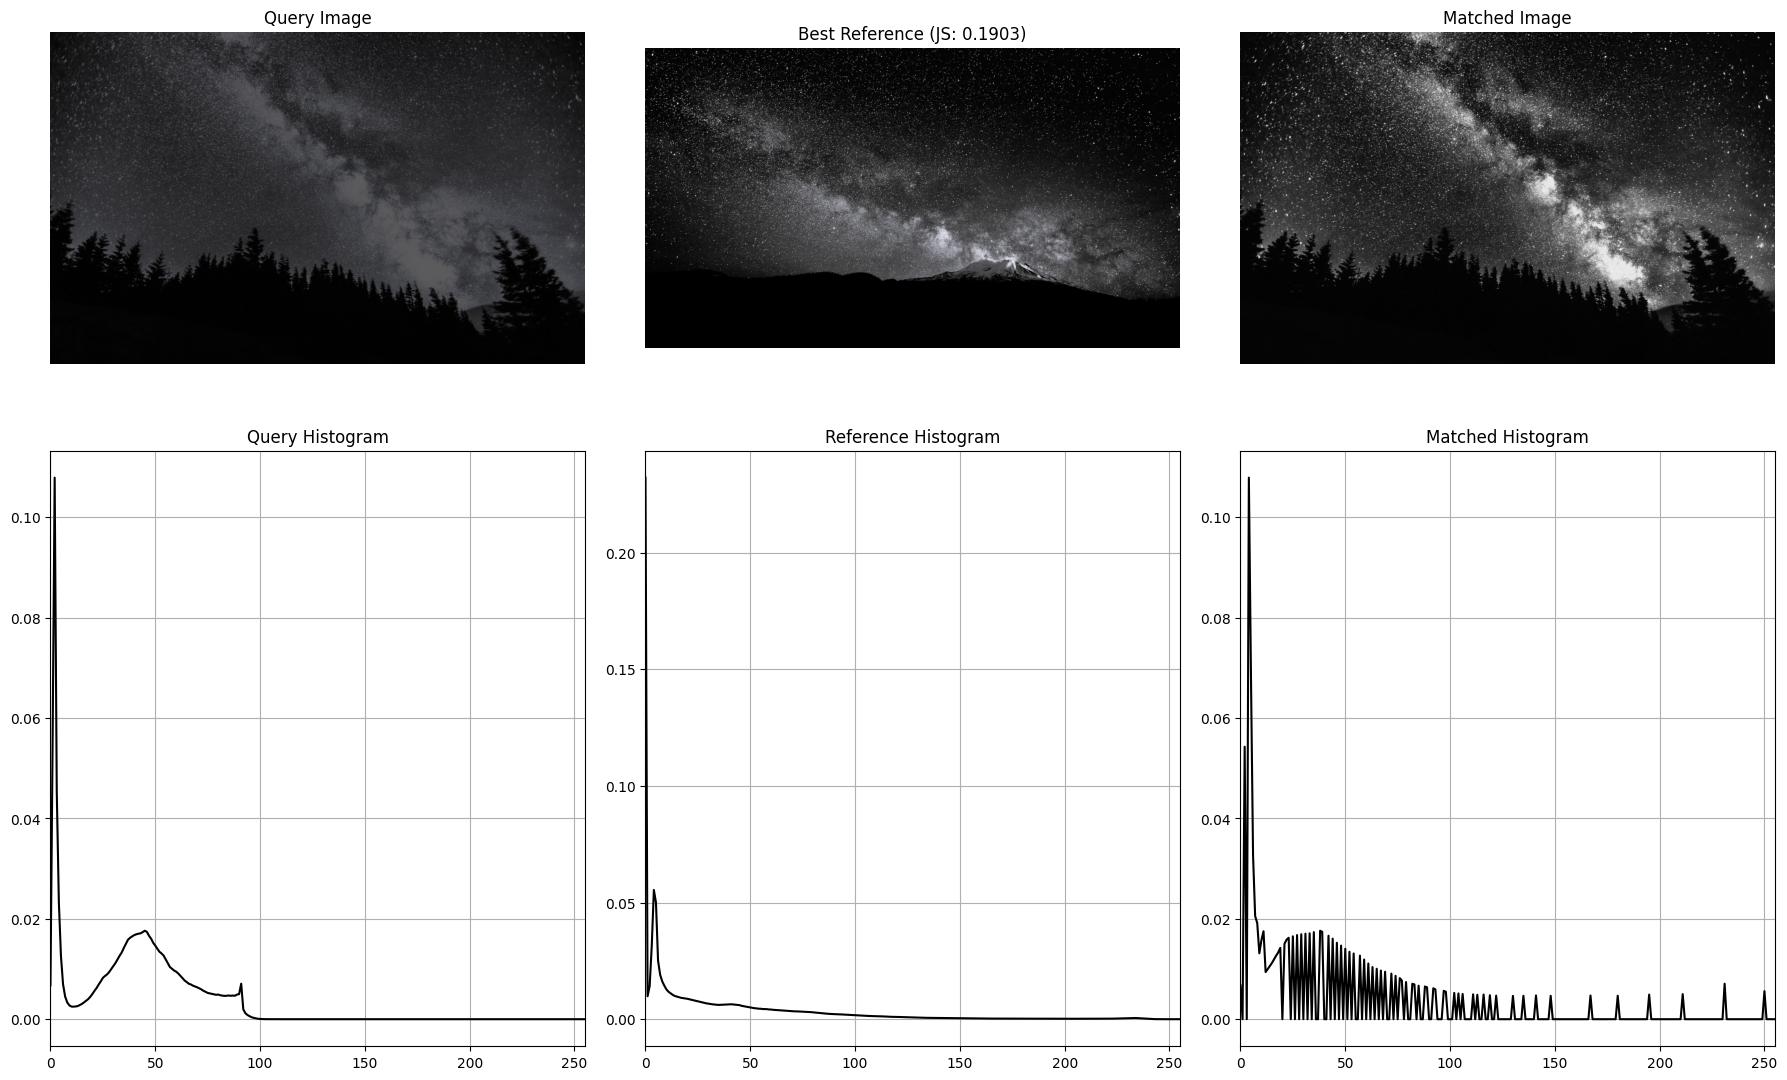

In [8]:
query_image_path = "galaxy-Q3.jpeg"  # آدرس تصویر کوئری

match_query_to_ref( query_image_path, reference_images_list)

<hr>
<div>
    <font size=5 color= navy>D) Portrait:
</div>

Query Image: Portrait-Q4.jpg - Best Match: galaxy-R3.jpg - JS Distance: 0.3804


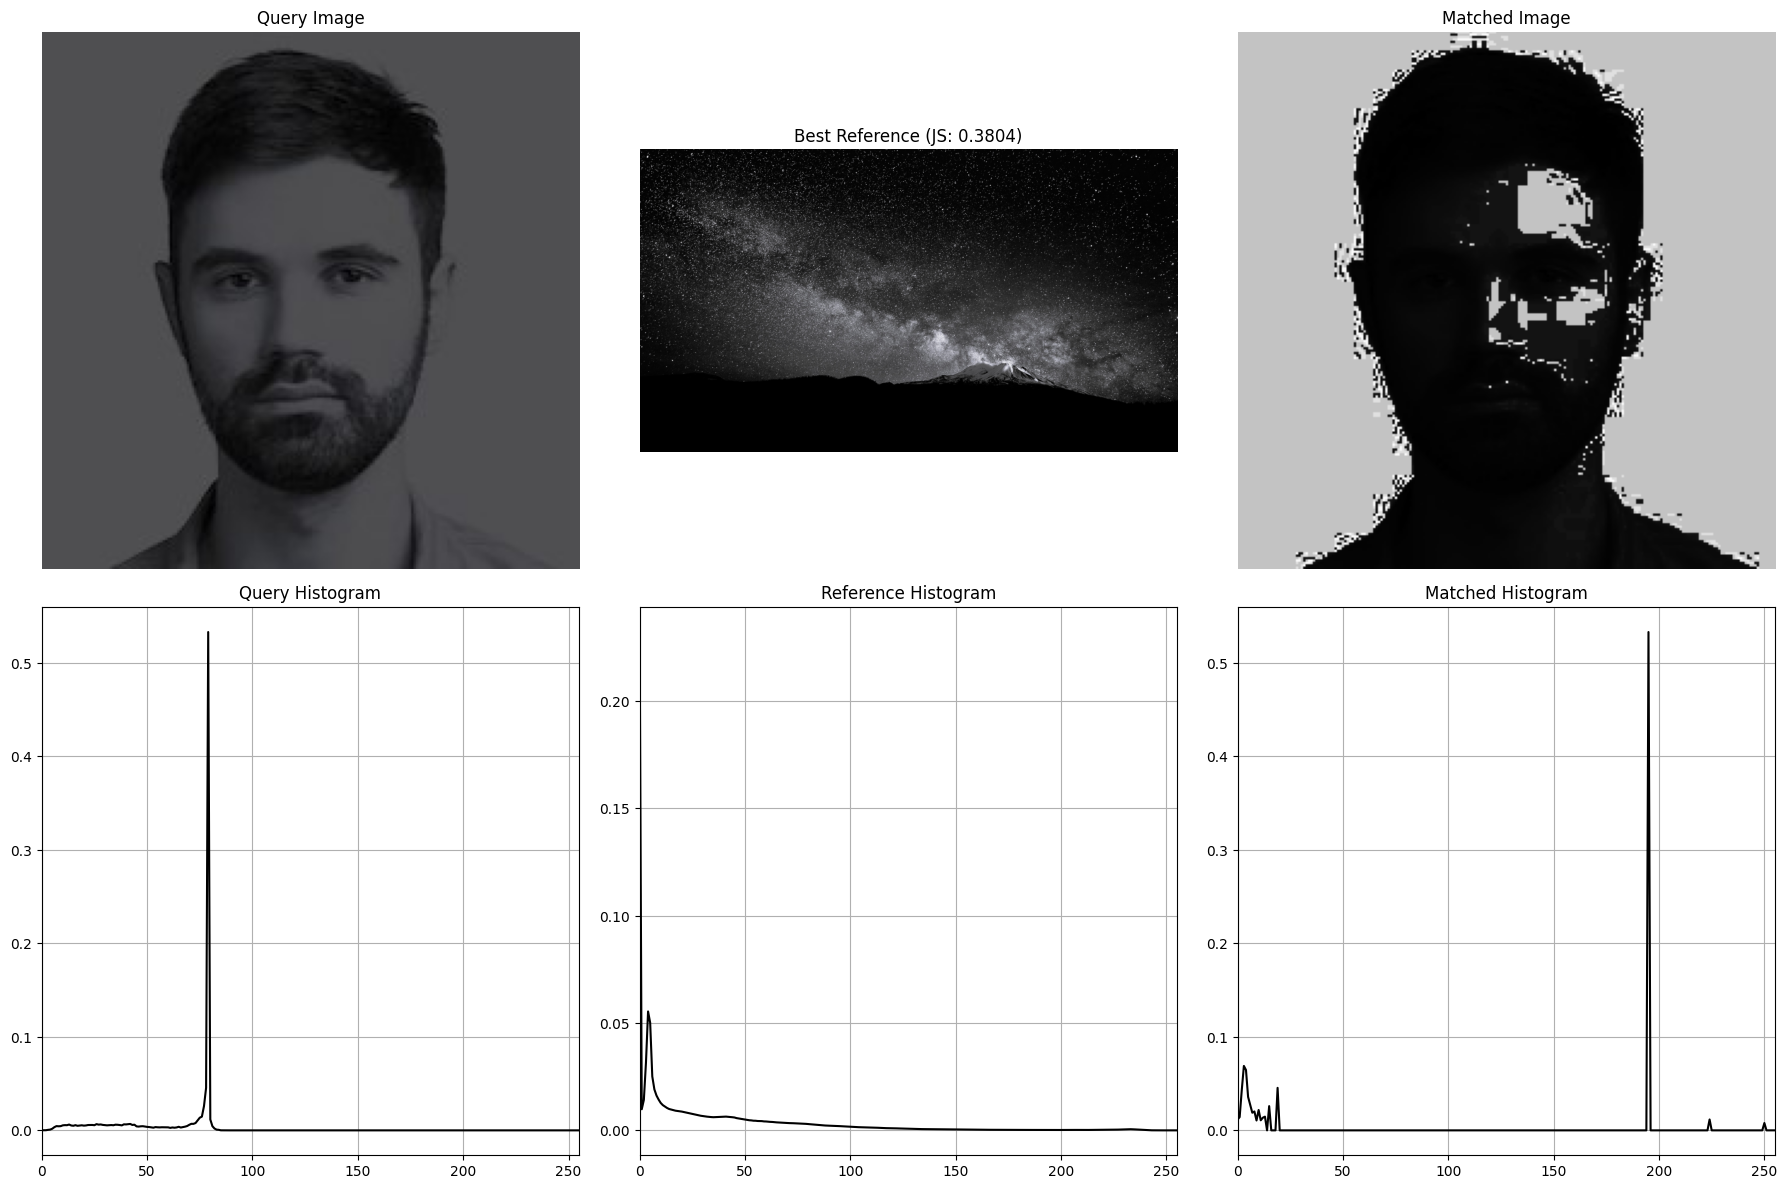

In [9]:
query_image_path = "Portrait-Q4.jpg"  # آدرس تصویر کوئری

match_query_to_ref( query_image_path, reference_images_list)

<hr><div>
    <font size=5 color= navy>E) Waterfall:
</div>

Query Image: waterfall-Q5.jpg - Best Match: galaxy-R3.jpg - JS Distance: 0.1085


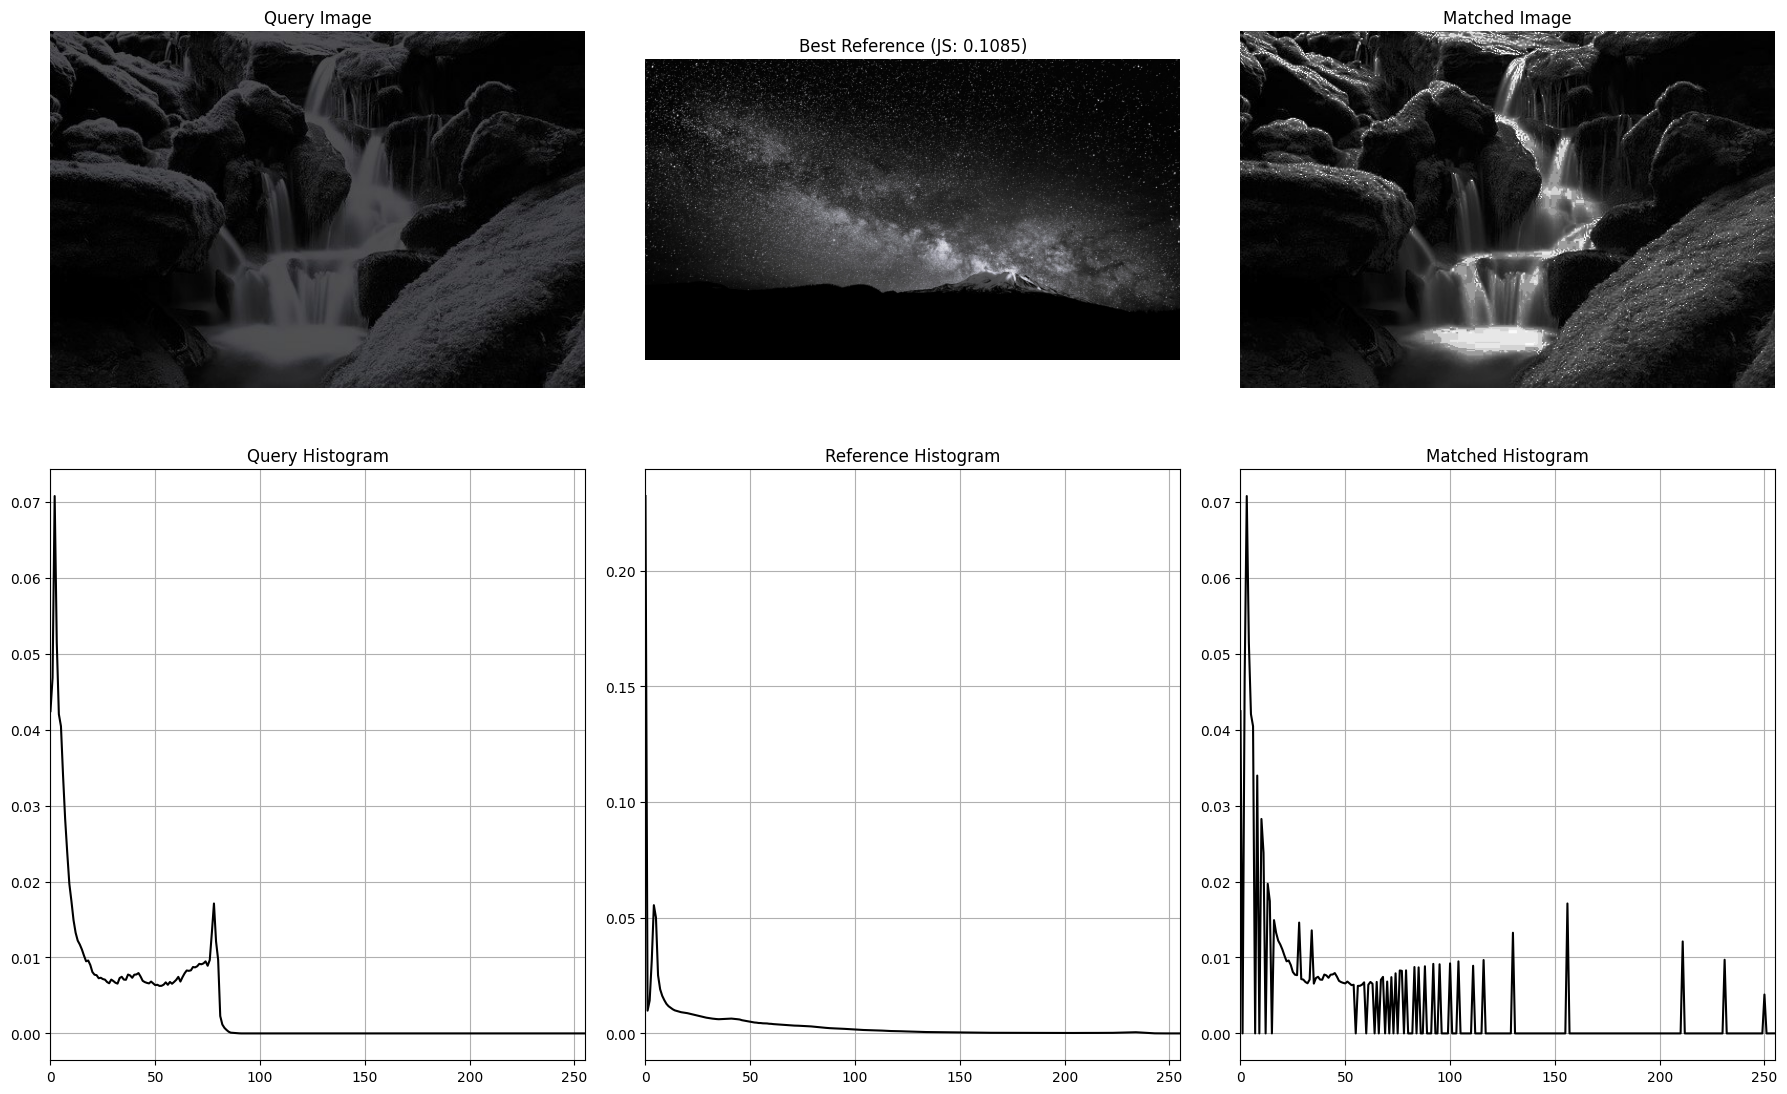

In [10]:
query_image_path = "waterfall-Q5.jpg"  # آدرس تصویر کوئری

match_query_to_ref( query_image_path, reference_images_list)

<hr>
<html lang="fa">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <style>
        body {
            font-family: Arial, sans-serif;
            direction: rtl;
            text-align: right;
            background-color: #f5f5f5;
            padding: 20px;
        }
        .container {
            background: white;
            padding: 20px;
            border-radius: 8px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
            max-width: 600px;
            margin: auto;
        }
        h2 {
            color: #333;
        }
        ol {
            padding-right: 20px;
        }
        code {
            background: #f0f0f0;
            padding: 2px 5px;
            border-radius: 3px;
            font-family: monospace;
        }
    </style>
</head>
<body>
    <div class="container">
        <h2>مکانیسم بهبود کیفیت تصویر:</h2>
        <ol>
            <li>با محاسبه فاصله جنسن-شانون، نزدیک‌ترین هیستوگرام مرجع به تصویر کوئری انتخاب می‌شود. (بهترین توزیع روشنایی)</li>
            <li>تنظیم کنتراست: با نگاشت پیکسل‌ها بر اساس CDF مرجع، کنتراست تصویر کوئری به مرجع شبیه‌سازی می‌شود.</li>
            <li>یکسان‌سازی طیف نوری: پیکسل‌های تصویر کوئری بازتوزیع می‌شوند تا طیف روشنایی تصویر هدف (مرجع) را تقلید کنند.</li>
        </ol>
    </div>
</body>
</html>